<a href="https://colab.research.google.com/github/pratapponnam/ProstateDetection/blob/main/CNNModel%20for%20one%20patient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.0 MB/s eta 0:00:00


In [24]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
import pydicom
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [32]:
# Paths to data files
findings_train_path = "/content/drive/MyDrive/ProstateX-Findings-Train1.csv"
images_train_path = "/content/drive/MyDrive/ProstateX-Images-Train1.csv"
dicom_dir = "/content/drive/MyDrive/Prostate/ProstateX-0000/"  # Update this path

# Load CSV files
findings_df = pd.read_csv(findings_train_path)
images_df = pd.read_csv(images_train_path)

# Merge the Findings and Images data
merged_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"], how="inner")

# Select relevant columns
merged_df = merged_df[["ProxID", "fid", "DCMSerDescr", "DCMSerNum", "ijk", "ClinSig"]]
merged_df["ClinSig"] = merged_df["ClinSig"].fillna(0).astype(int)


In [30]:
import glob
# Function to load DICOM images based on matched series descriptions
def load_relevant_dicom_images(dicom_dir, merged_df, img_size=(128, 128)):
    images = []
    labels = []
    matched_records = 0

    # Get all DICOM file paths using glob
    dicom_files = glob.glob(os.path.join(dicom_dir, "**/*.dcm"), recursive=True)
    print(f"Found {len(dicom_files)} DICOM files.")
    if len(dicom_files) == 0:
        print("No DICOM files found. Check the directory path.")
        return np.array(images), np.array(labels)

    for _, row in merged_df.iterrows():
        series_desc = row["DCMSerDescr"]
        series_num = row["DCMSerNum"]
        label = row["ClinSig"]

        matched = False  # Flag to prevent unnecessary looping
        for dicom_path in dicom_files:
            dicom = pydicom.dcmread(dicom_path)

            if dicom.SeriesNumber == series_num and series_desc in dicom.SeriesDescription:
                img = dicom.pixel_array
                img = img.astype(np.float32)
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                img = np.expand_dims(img, axis=-1)  # Ensure 3D format (H, W, 1)
                img = tf.image.resize(img, img_size)

                images.append(img.numpy())
                labels.append(label)
                matched_records += 1
                matched = True
                break  # Stop checking once a match is found

        if not matched:
            print(f"No match found for SeriesNumber {series_num} and Description {series_desc}")

    print(f"Total matched records: {matched_records}")
    return np.array(images), np.array(labels)

In [33]:

# Load dataset
img_size = (128, 128)
X, y = load_relevant_dicom_images(dicom_dir, merged_df, img_size)

Found 884 DICOM files.
No match found for SeriesNumber 8 and Description ep2d_diff_tra_DYNDIST_MIX_ADC
No match found for SeriesNumber 7 and Description ep2d_diff_tra_DYNDIST_MIX
No match found for SeriesNumber 7 and Description ep2d_diff_tra_DYNDIST_MIX
No match found for SeriesNumber 7 and Description ep2d_diff_tra_DYNDIST_MIX
No match found for SeriesNumber 9 and Description ep2d_diff_tra_DYNDIST_MIXCALC_BVAL
No match found for SeriesNumber 3 and Description t2_loc sag
No match found for SeriesNumber 1 and Description t2_localizer
No match found for SeriesNumber 2 and Description t2_localizer
No match found for SeriesNumber 4 and Description t2_tse_sag
No match found for SeriesNumber 6 and Description t2_tse_tra
No match found for SeriesNumber 10 and Description t2_tse_tra
No match found for SeriesNumber 11 and Description tfl_3d PD ref_tra_1.5x1.5_t3
No match found for SeriesNumber 2 and Description t2_loc sag
No match found for SeriesNumber 2 and Description t2_loc sag
No match fo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 585ms/step - accuracy: 0.5559 - loss: 0.6909 - val_accuracy: 0.6842 - val_loss: 0.6901
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.6699 - loss: 0.6135 - val_accuracy: 0.6842 - val_loss: 0.6484
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 786ms/step - accuracy: 0.7394 - loss: 0.5968 - val_accuracy: 0.6842 - val_loss: 0.6518
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.7168 - loss: 0.5685 - val_accuracy: 0.6842 - val_loss: 0.6603
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - accuracy: 0.6473 - loss: 0.6379 - val_accuracy: 0.6842 - val_loss: 0.6543
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.6890 - loss: 0.6410 - val_accuracy: 0.6842 - val_loss: 0.6660
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - accuracy: 0.6855 - loss: 0.6100 - val_accuracy: 0.6842 - val_loss: 0.6679
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 756ms/step - accuracy: 0.6499 - loss: 0.6290 - val_accuracy: 0.6842 - val_loss:

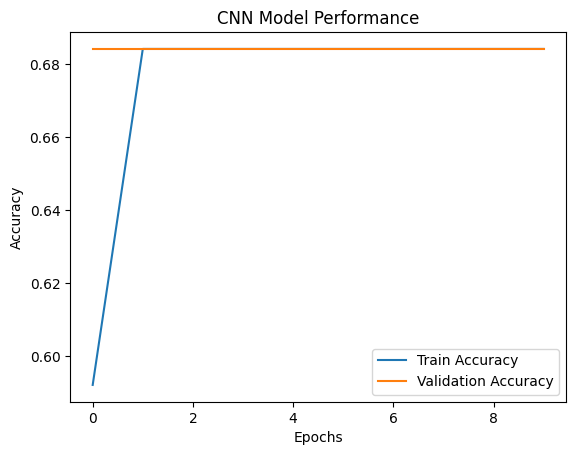

In [28]:
# One-hot encode labels
y = to_categorical(y, 2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN Model
def build_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build and train CNN model
model = build_cnn_model(input_shape=(128, 128, 1), num_classes=2)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Model Performance")
plt.show()

# Save the model
model.save("dicom_cnn_model.h5")
